In [1]:
# Load required librabries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset 
customer = pd.read_csv('QVI_purchase_behaviour.csv')
transaction = pd.read_excel('QVI_transaction_data.xlsx')

## Exploratory data analysis (EDA)

In [4]:
print(transaction.info())
transaction.head() 
# no missing vaalues in dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
None


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
# Convert DATE column into date format
transaction['DATE'] = pd.to_datetime("1899-12-30") + pd.to_timedelta(transaction['DATE'], unit="D")

In [6]:
# PROD_NAME column
all_production_names = transaction['PROD_NAME'].unique()
all_words = []
for name in all_production_names:
    all_words.extend(name.split())
cleaned_words = [word for word in all_words if re.match("^[A-Za-z]+$", word)]
word_counts = Counter(cleaned_words)
print(word_counts.most_common(20))

[('Chips', 21), ('Smiths', 16), ('Crinkle', 14), ('Cut', 14), ('Kettle', 13), ('Cheese', 12), ('Salt', 12), ('Original', 10), ('Chip', 9), ('Salsa', 9), ('Doritos', 9), ('Corn', 8), ('Pringles', 8), ('RRD', 8), ('Chicken', 7), ('WW', 7), ('Sour', 6), ('Sea', 6), ('Thinly', 5), ('Vinegar', 5)]


In [7]:
# Remove Salsa
transaction = transaction[~transaction['PROD_NAME'].str.contains('Salsa')]

In [8]:
# Outliers
transaction.describe()
# PROD_QTY = 200 is outliers 
transaction[transaction['PROD_QTY'] == 200]
transaction[transaction['LYLTY_CARD_NBR'] == 226000] 
#this customer has only had two transactions over the year 
#and is not an ordinary retail customer.
#The customer might be buying chips for commercial purposes instead.
#We'll remove this loyalty card number from further analysis.
transaction = transaction[transaction['LYLTY_CARD_NBR'] != 226000]
transaction_by_date = transaction.groupby('DATE').size().reset_index(name= 'transaction_count')

In [9]:
transaction_by_date['DATE'].nunique() # There is a missing day that with no transaction
full_dates = pd.date_range(start = '2018-07-01', end = '2019-06-30')
full_dates_df = pd.DataFrame({'DATE':full_dates})
transaction_merge = pd.merge(full_dates_df, transaction_by_date, on = 'DATE', how = 'left')
transaction_merge.fillna(0, inplace = True)

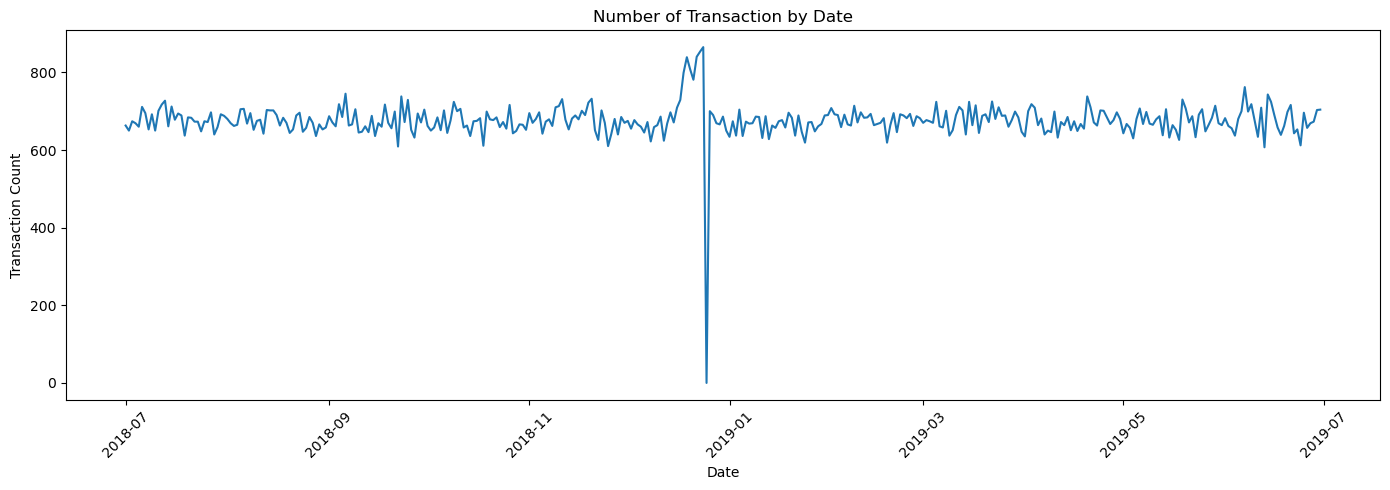

In [10]:
plt.figure(figsize = (14,5))
plt.plot(transaction_merge['DATE'], transaction_merge['transaction_count'])
plt.title('Number of Transaction by Date')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

We can see that there is an increase in purchases in December and a break in late December. Let's zoom in on this.

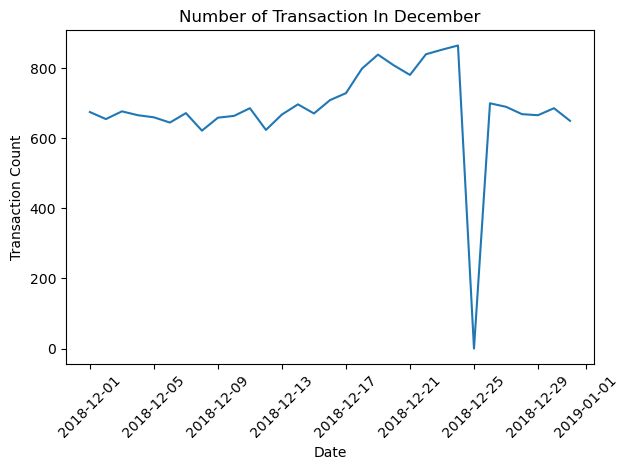

In [12]:
transaction_in_december = transaction_merge[transaction_merge['DATE'].dt.month == 12]
plt.plot(transaction_in_december['DATE'], transaction_in_december['transaction_count'])
plt.title('Number of Transaction In December')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

In [14]:
# Create a new features - PACK_SIZE
transaction['PACK_SIZE'] = transaction['PROD_NAME'].str.extract('(\d+)', expand = False).astype(int)
transaction['PACK_SIZE'].value_counts().sort_index()
# The largest size is 380g and the smallest size is 70g

PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64

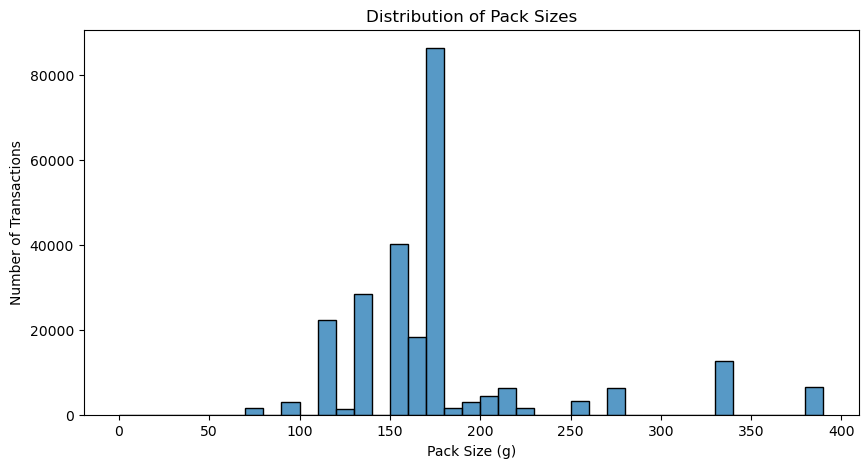

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(transaction['PACK_SIZE'], bins=range(0, 400, 10), kde=False)
plt.title('Distribution of Pack Sizes')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.show()

In [16]:
# Create a new features - BRAND
transaction['PROD_NAME'] = transaction['PROD_NAME'].str.replace(r'\s+', ' ', regex=True).str.strip() # Remove extra space in the product name
Brand_list = {
    'natural chip compny': 'Natural Chip Company',
    'natural chip co':'Natural Chip Company',
    'natural ChipCo':'Natural Chip Company',
    'natural chipco':'Natural Chip Company',
    'ccs':"CCs",
    'ncc':'Natural Chip Company',
    'ww':'Woolworths',
    'Woolworths':'Woolworths',
    'woolworths':'Woolworths',
    'infzns':'Infuzions',
    'Infuzions':'infuzions',
    'doritos':'Doritos',
    'dorito':'Doritos',
    'grnwves':'Grain Waves',
    'grain waves':'Grain Waves',
    'red rock deli':'Red Rock Deli',
    'rrd':'Red Rock Deli',
    'RRD':'Red Rock Deli',
    'smiths':'Smiths',
    'smith':'Smiths',
    'kettle':'Kettle',
    'Pringles':'Pringles',
    'pringles':'Pringles',
    'Twisties':'Twisties',
    'twisties':'Twisties', 
    'Tostitos':'Tostitos',
    'Thins':'Thins',
    'thins chips': 'Thins',
    'thins':'Thins',
    'Cheetos':'Cheetos',
    'cheetos':'Cheetos',
    'tostitos':'Tostitos',
    'tyrrells':'Tyrrells',
    'cobs':'Cobs',
    'snbts':'Sunbites',
    'sunbites':'Sunbites',
}

def get_brand(prod_name):
    prod_name = str(prod_name).lower()
    for wrong, correct in Brand_list.items():
        if wrong in prod_name:
            return correct
    return 'Other'
transaction['BRAND'] = transaction['PROD_NAME'].apply(get_brand)

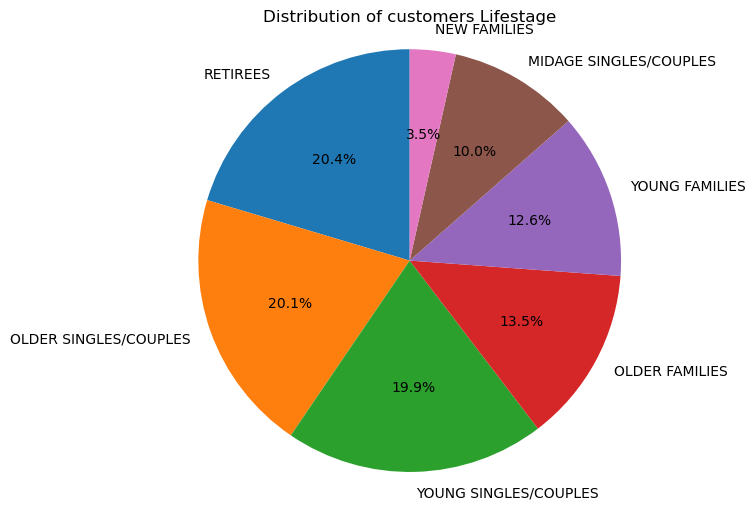

In [17]:
# customer dataset 
lifestage_counts = customer['LIFESTAGE'].value_counts().reset_index() # PREMIUM_CUSTOMER
premium_counts = customer['PREMIUM_CUSTOMER'].value_counts().reset_index()

plt.figure(figsize = (6,6))
plt.pie(lifestage_counts['count'], labels = lifestage_counts['LIFESTAGE'], autopct = '%1.1f%%', startangle = 90)
plt.title('Distribution of customers Lifestage')
plt.axis('equal')
plt.show()

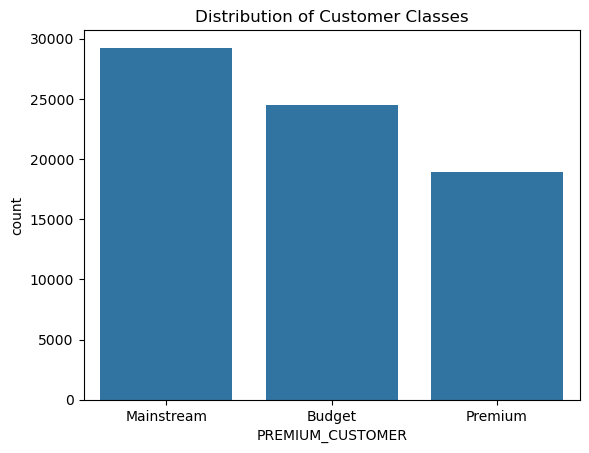

In [18]:
sns.barplot(x = 'PREMIUM_CUSTOMER', y = 'count', data = premium_counts)
plt.title('Distribution of Customer Classes')
plt.show()

In [19]:
final = transaction.merge(customer, on = 'LYLTY_CARD_NBR', how = 'left')
final.to_csv("QVI_data.csv", index = False)

## Data analysis on Customer Segments
- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment?
- How many chips are bought per customer by segment?
- What's the average chip price by customer segment?
- The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips

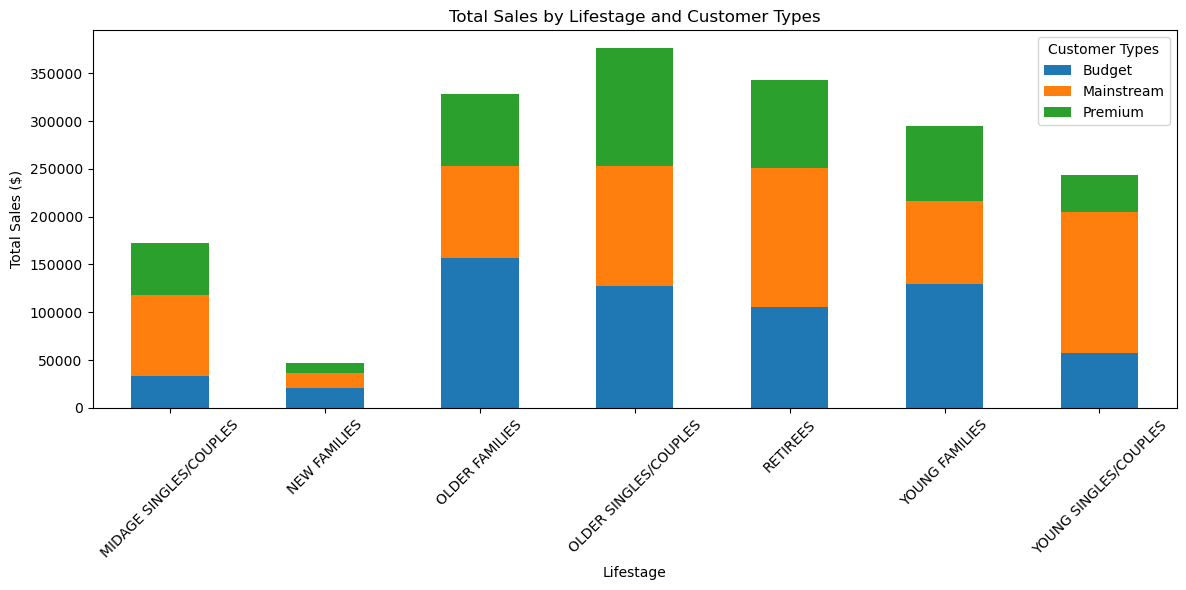

In [21]:
# Who spends the most on chips (total sales)?
sales_summary = final.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().reset_index()
sales_pivot = sales_summary.pivot(index = 'LIFESTAGE', columns = 'PREMIUM_CUSTOMER', values = 'TOT_SALES').fillna(0)

sales_pivot.plot(kind = 'bar', stacked = True, figsize = (12,6))

plt.title('Total Sales by Lifestage and Customer Types')
plt.ylabel('Total Sales ($)')
plt.xlabel('Lifestage')
plt.xticks(rotation = 45)
plt.legend(title = 'Customer Types')
plt.tight_layout()
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees.

Let's see if the higher sales are due to there being more customers who buy chips.

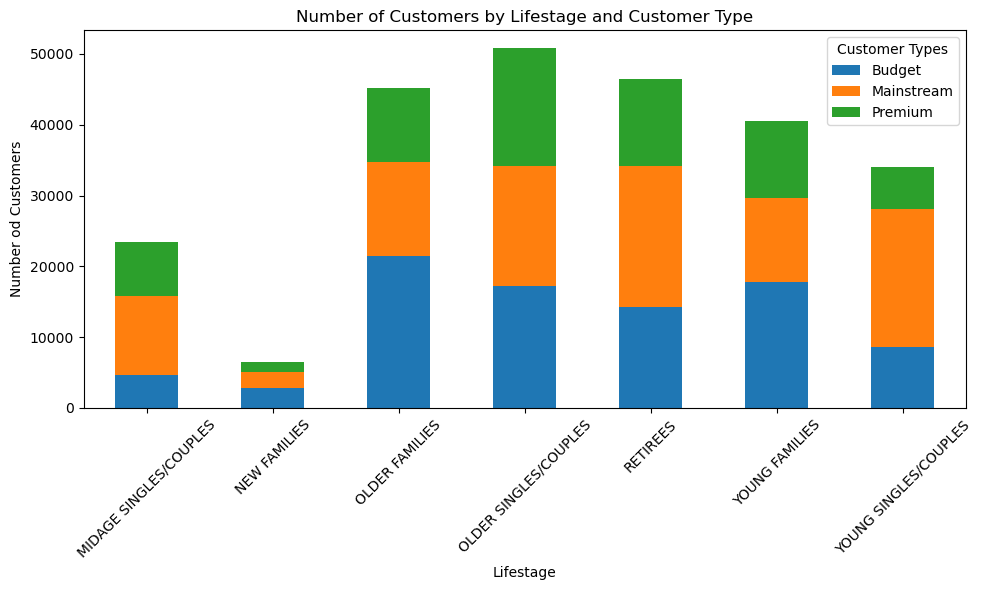

In [23]:
customer_summary = final.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).size().reset_index(name = 'Customer Counts')
customer_pivot = customer_summary.pivot(index = 'LIFESTAGE', columns = 'PREMIUM_CUSTOMER', values = 'Customer Counts').fillna(0)

customer_pivot.plot(kind = 'bar', stacked = True, figsize = (10,6))
plt.title('Number of Customers by Lifestage and Customer Type')
plt.ylabel('Number od Customers')
plt.xlabel('Lifestage')
plt.xticks(rotation = 45)
plt.legend(title = 'Customer Types')
plt.tight_layout()
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. 
This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.
Higher sales may also be driven by more units of chips being bought per customer.

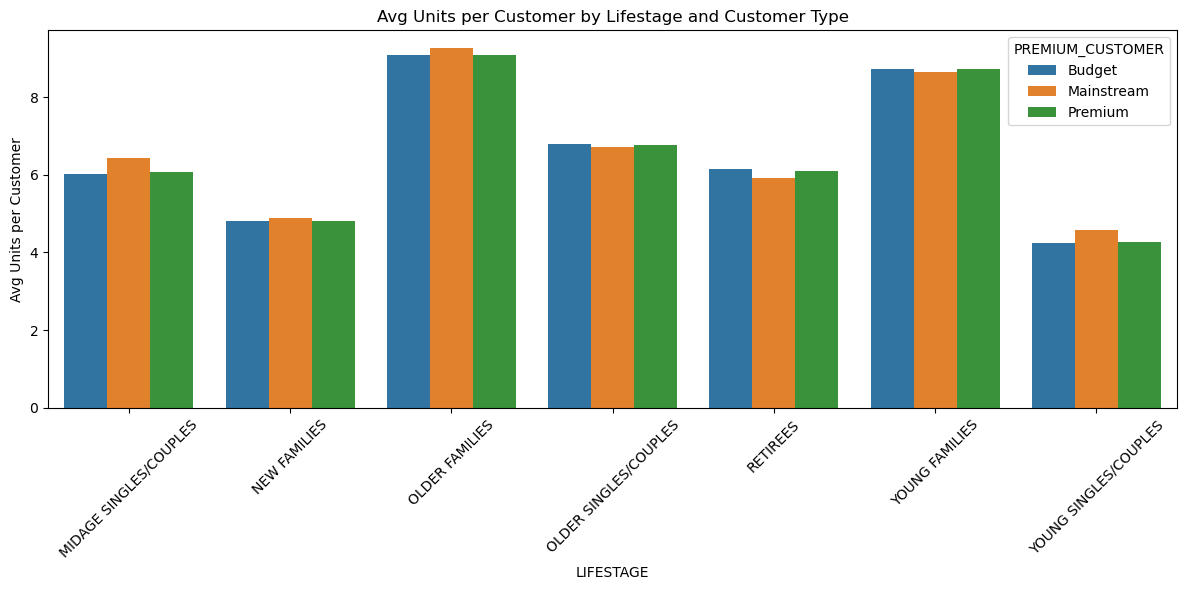

In [25]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units = final.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).agg(
    total_units = ('PROD_QTY', 'sum'),
    num_customers = ('LYLTY_CARD_NBR', 'nunique')
).reset_index()

avg_units['avg_units_per_customer'] = avg_units['total_units'] / avg_units['num_customers']
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=avg_units,
    x='LIFESTAGE',
    y='avg_units_per_customer',
    hue='PREMIUM_CUSTOMER'
)
plt.title('Avg Units per Customer by Lifestage and Customer Type')
plt.xticks(rotation=45)
plt.ylabel('Avg Units per Customer')
plt.tight_layout()
plt.show()

Older families and young families in general buy more chips per customer. 

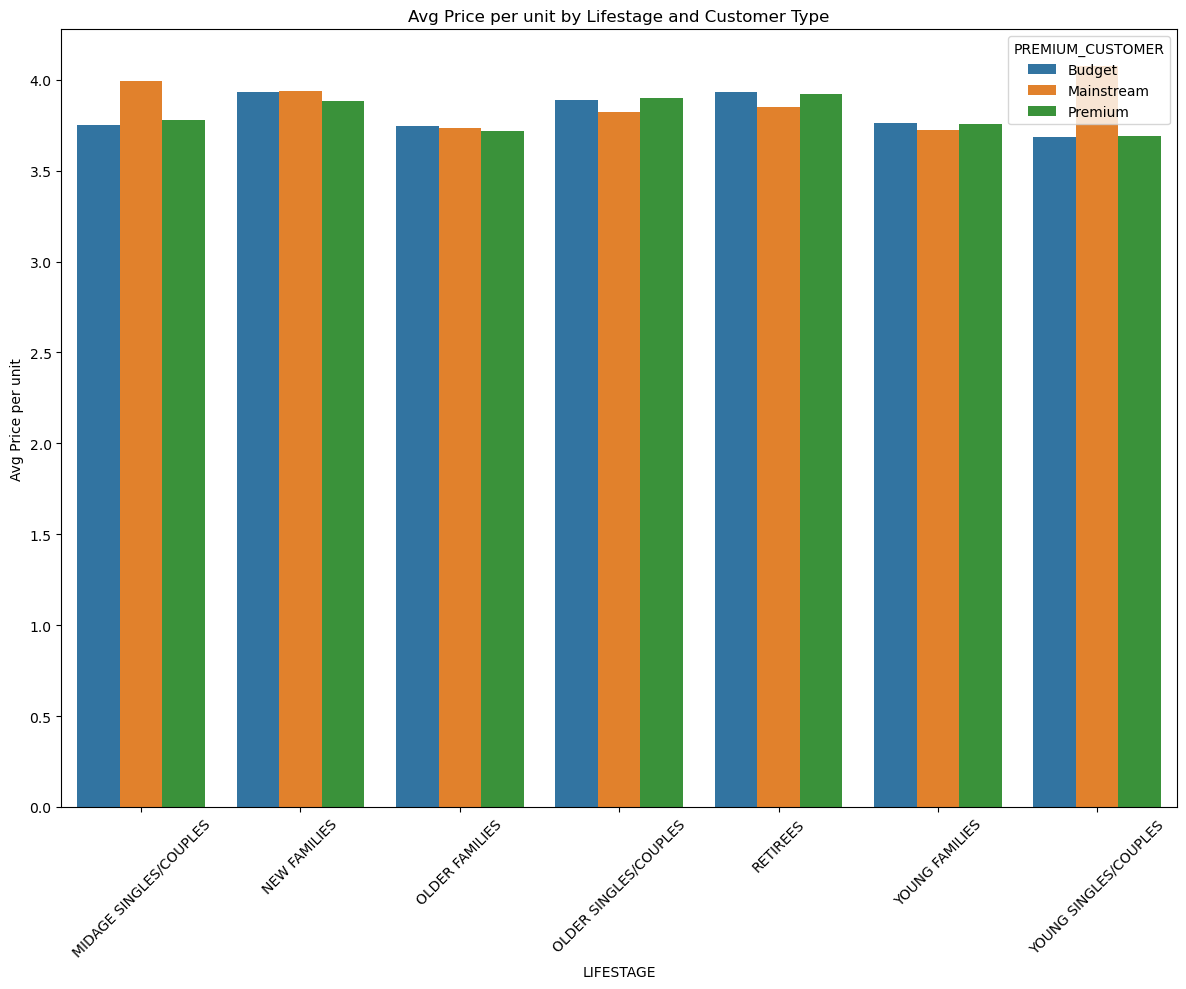

In [27]:
# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
avg_price_unit = final.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).agg(
    total_unit = ('PROD_QTY', 'sum'),
    total_revenue = ('TOT_SALES', 'sum')
).reset_index()
avg_price_unit['Average_unit_price'] = avg_price_unit['total_revenue'] / avg_price_unit['total_unit']

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=avg_price_unit,
    x='LIFESTAGE',
    y='Average_unit_price',
    hue='PREMIUM_CUSTOMER'
)
plt.title('Avg Price per unit by Lifestage and Customer Type')
plt.xticks(rotation=45)
plt.ylabel('Avg Price per unit')
plt.tight_layout()
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption.

This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

In [29]:
# Perform an independent t-test between mainstream vs premium and budget midage and young singles and couples
subset = final[
    final['LIFESTAGE'].str.contains('SINGLES/COUPLES') &
    final['LIFESTAGE'].str.contains('YOUNG|MIDAGE')
]
subset['UNIT_PRICE'] = subset['TOT_SALES'] / subset['PROD_QTY']

from scipy.stats import ttest_ind
mainstream_price = subset[subset['PREMIUM_CUSTOMER'] == 'Mainstream']['UNIT_PRICE']
other_price = subset[subset['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium'])]['UNIT_PRICE']

t_stat, p_value = ttest_ind(mainstream_price, other_price, equal_var = False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

T-statistic: 37.624, p-value: 0.0000


The t-test results in a p-value of less than 0.05, i.e. the unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.

In [31]:
# Deep dive into Mainstream, young singles/couples 
segment = final[
    (final['PREMIUM_CUSTOMER'] == 'Mainstream') &
    (final['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')
]

brand_counts_segment = segment['BRAND'].value_counts()
brand_counts_all = final['BRAND'].value_counts()

lift = (brand_counts_segment / brand_counts_segment.sum()) / (brand_counts_all / brand_counts_all.sum())
lift.sort_values(ascending = False)

BRAND
Tyrrells                1.213098
Twisties                1.201858
Doritos                 1.190712
Tostitos                1.186370
Kettle                  1.175400
Pringles                1.164310
Infuzions               1.156474
Cobs                    1.125335
Grain Waves             1.053702
Thins                   1.045867
Other                   0.980623
Smiths                  0.799009
Cheetos                 0.715997
Red Rock Deli           0.676842
Natural Chip Company    0.665978
CCs                     0.615846
Sunbites                0.537228
Woolworths              0.510924
Name: count, dtype: float64

Affinity analysis reveals that Mainstream young singles/couples show a strong preference for Tyrrells, Twisties, and Doritos with lift values exceeding 1.2. In contrast, brands like Woolworths and Red Rock Deli underperformance 

In [33]:
# Remove the non-chip product
final = final[~final['PROD_NAME'].str.contains('Dip')]

# Modify the G for ship size and create a column (WEIGHT) for it
final['PROD_NAME'] = final['PROD_NAME'].str.lower() #convert to lowercase
final['WEIGHT'] = final['PROD_NAME'].str.extract(r'(\d+s*g)') #extract weight for chips

# Remove weight from product name 
final['PROD_NAME'] = final['PROD_NAME'].str.replace(r'\d+\s*g', '', regex=True)
# Remove extra spaces in product Names
final['PROD_NAME'] = final['PROD_NAME'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [34]:
final.describe() 
# 200 chips in one purchase -> outliers
final = final.drop(final[final['PROD_QTY'] == 200].index)

In [35]:
Brand_list = {
    'natural chip compny': 'Natural Chip Company',
    'natural chip co':'Natural Chip Company',
    'natural ChipCo':'Natural Chip Company',
    'natural chipco':'Natural Chip Company',
    'ccs':"CCs",
    'ncc':'Natural Chip Company',
    'ww':'Woolworths',
    'Woolworths':'Woolworths',
    'woolworths':'Woolworths',
    'infzns':'Infuzions',
    'Infuzions':'infuzions',
    'doritos':'Doritos',
    'dorito':'Doritos',
    'grnwves':'Grain Waves',
    'grain waves':'Grain Waves',
    'red rock deli':'Red Rock Deli',
    'rrd':'Red Rock Deli',
    'RRD':'Red Rock Deli',
    'smiths':'Smiths',
    'smith':'Smiths',
    'kettle':'Kettle',
    'Pringles':'Pringles',
    'pringles':'Pringles',
    'Twisties':'Twisties',
    'twisties':'Twisties', 
    'Tostitos':'Tostitos',
    'Thins':'Thins',
    'thins chips': 'Thins',
    'thins':'Thins',
    'Cheetos':'Cheetos',
    'cheetos':'Cheetos',
    'tostitos':'Tostitos',
    'tyrrells':'Tyrrells',
    'cobs':'Cobs',
    'snbts':'Sunbites',
    'sunbites':'Sunbites',
}
for wrong_name, correct_name in Brand_list.items():
    final['PROD_NAME'] = final['PROD_NAME'].str.replace(
        rf'\b{re.escape(wrong_name)}\b',  # replace the word that is EXCATLY SAME with the Brand_list
        correct_name,
        regex=True
    )

In [36]:
# create Brand column and remove brand name from PROD_NAME
brand_pattern = '|'.join(re.escape(name) for name in Brand_list.values())
final['BRAND'] = final['PROD_NAME'].str.extract(f'({brand_pattern})', flags=re.IGNORECASE)
final['BRAND'].fillna('Other', inplace = True)
final['PROD_NAME'] = final['PROD_NAME'].str.replace(f'({brand_pattern})', '', regex=True)
final['PROD_NAME'] = final['PROD_NAME'].str.strip()

In [37]:
Cut_types = {
    'crnkle':'Crinkle',
    'crinkle cut':'Crinkle',
    'crinkle':'Crinkle',
    'chip thinly':'Thinly',
    'thinly cut':'Thinly',
    'thinly':'Thinly',
    'strws':'Straws',
}
for old, new in Cut_types.items():
    final['PROD_NAME'] = final['PROD_NAME'].str.replace(rf'\b{old}\b', new, regex = True)
    
chip_base = {
    'potato chips':'Potato',
    'corn chips':'Corn', 
    'corn chip':'Corn',
    'corn chp':'Corn',
    'crn crnchers':'Corn',
    'swt pot':'Sweet Potato',
    'tortilla':'Corn',
    'whlegrn crisps':'Whole Grain',
    'papadums':'Legume',
    'popd':'Mixed',
}

for old, new in chip_base.items():
    final['PROD_NAME'] = final['PROD_NAME'].apply(
       lambda x: f"{x} {new}" if re.search(rf'\b{re.escape(old)}\b', x, flags=re.IGNORECASE) else x 
    )

for word in chip_base.keys():
    final['PROD_NAME'] = final['PROD_NAME'].str.replace(rf'\b{word}\b'," ", regex = True)

In [38]:
final

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,WEIGHT
0,2018-10-17,1,1000,1,5,seasalt,2,6.0,175,Natural Chip Company,YOUNG SINGLES/COUPLES,Premium,175g
1,2019-05-14,1,1307,348,66,nacho cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,175g
2,2019-05-20,1,1343,383,61,Crinkle chips chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,170g
3,2018-08-17,2,2373,974,69,Thinly s/cream&onion,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,175g
4,2018-08-18,2,2426,1038,108,chpshny&jlpno chili Corn,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,150g
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,sweet chilli and sour cream,2,10.8,175,Kettle,YOUNG SINGLES/COUPLES,Premium,175g
246736,2018-08-13,272,272358,270154,74,splash of lime,1,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium,175g
246737,2018-11-06,272,272379,270187,51,mexicana,2,8.8,170,Doritos,YOUNG SINGLES/COUPLES,Premium,170g
246738,2018-12-27,272,272379,270188,42,mexican jalapeno Corn,2,7.8,150,Doritos,YOUNG SINGLES/COUPLES,Premium,150g


In [39]:
# Create Cut type and chip base features

cut_pattern = '|'.join(re.escape(name) for name in Cut_types.values())
base_pattern = '|'.join(re.escape(name) for name in chip_base.values())
final['CUT_TYPE'] = final['PROD_NAME'].str.extract(f'({cut_pattern})', flags=re.IGNORECASE)
final['CHIP_BASE'] = final['PROD_NAME'].str.extract(f'({base_pattern})', flags=re.IGNORECASE)
# Fix missing values 
final['CUT_TYPE'].fillna('Classic', inplace = True)
final['CHIP_BASE'].fillna('Potato', inplace = True)
final['CHIP_BASE'] = final['CHIP_BASE'].str.title()
# remove extra spaces and clean product name 
final['PROD_NAME'] = final['PROD_NAME'].str.replace(f'({base_pattern})', '', regex=True)
final['PROD_NAME'] = final['PROD_NAME'].str.replace(f'({cut_pattern})', '', regex=True)
final['PROD_NAME'] = final['PROD_NAME'].str.strip()

In [40]:
final['PROD_NAME'] = final['PROD_NAME'].str.replace('&', ' and ')
final['FLAVOR'] = final['PROD_NAME']
typos = {
    's/cream': 'Sour Cream',
    'sr/cream':'Sour Cream',
    'sourcream onion':'Sour Cream and Onion',
    'garden':'',
    'sea salt':'Seasalt',
    'salted':'Salt',
    'seasonedchicken':'Seasoned Chicken',
    'swt chli':'Sweet Chilli',
    'spcy':'Spicy',
    'mzzrlla':'mozzarella',
    'sweetchili':'Sweet Chilli',
    'mac n cheese': 'Mac and Cheese',
    'chikn':'Chicken',
    'cutsalt/vinegr':'Salt and Vinegar',
    'chs':'Cheese',
    'slt vingar':'Salt and Vinegar',
    'orgnl':'orginal',
    'sour cream and onionstacked chips':'Sour Cream and Onion', 
}

final['PROD_NAME'] = final['PROD_NAME'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [41]:
final.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,245302,245302.000000,2.453020e+05,2.453020e+05,245302.000000,245302.000000,245302.000000,245302.000000
mean,2018-12-30 01:25:30.420461056,135.052580,1.355344e+05,1.351333e+05,56.055307,1.906585,7.330277,175.733496
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.001400e+04,6.755825e+04,26.000000,2.000000,5.800000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351855e+05,52.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030860e+05,2.026648e+05,86.000000,2.000000,8.800000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000,380.000000
std,NaN,76.796276,8.074650e+04,7.815827e+04,33.569313,0.342363,2.474134,59.573682


# Gerneral Exploration

1. Overall Transaction Time Trands

In [43]:
daily_counts = final.groupby('DATE').size().reset_index(name = 'transactions')
# Create a day-to-day list
full_dates = pd.DataFrame({'DATE': pd.date_range(start='2018-07-01', end='2019-06-30')})

# merge them together
daily_counts_full = pd.merge(full_dates, daily_counts, on='DATE', how='left')

# filling missing value
daily_counts_full['transactions'].fillna(0, inplace=True)
daily_counts_full.sort_values(by = 'transactions', ascending = False)

,DATE,transactions
176,2018-12-24,859.0
175,2018-12-23,843.0
174,2018-12-22,838.0
171,2018-12-19,831.0
172,2018-12-20,802.0
...,...,...
109,2018-10-18,608.0
83,2018-09-22,608.0
347,2019-06-13,606.0
147,2018-11-25,606.0


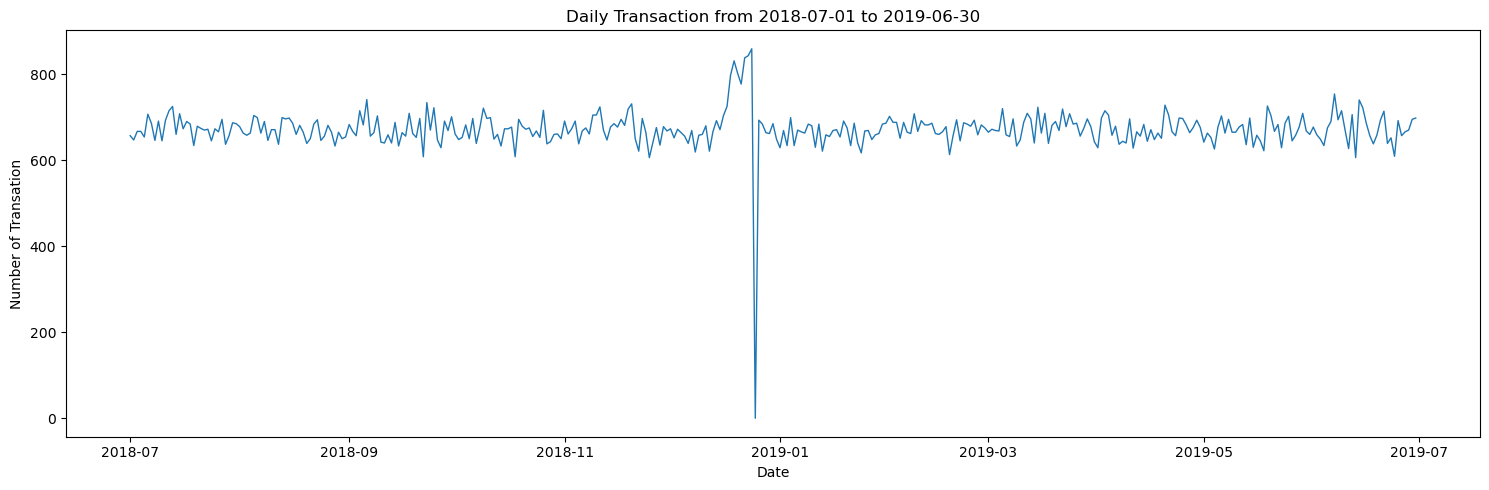

In [44]:
plt.figure(figsize = (15,5))
plt.plot(daily_counts_full['DATE'], daily_counts_full['transactions'], linewidth = 1)
plt.title('Daily Transaction from 2018-07-01 to 2019-06-30')
plt.xlabel('Date')
plt.ylabel('Number of Transation')
plt.tight_layout()
plt.show()

From the above line chart, we understand that the company was closed on Christmas Day, so 0 chips were sold on that day. 

Otherwise, the average sales for chips in this financial year is around **700 bags per day**. 

# Customer Segmented Analysis

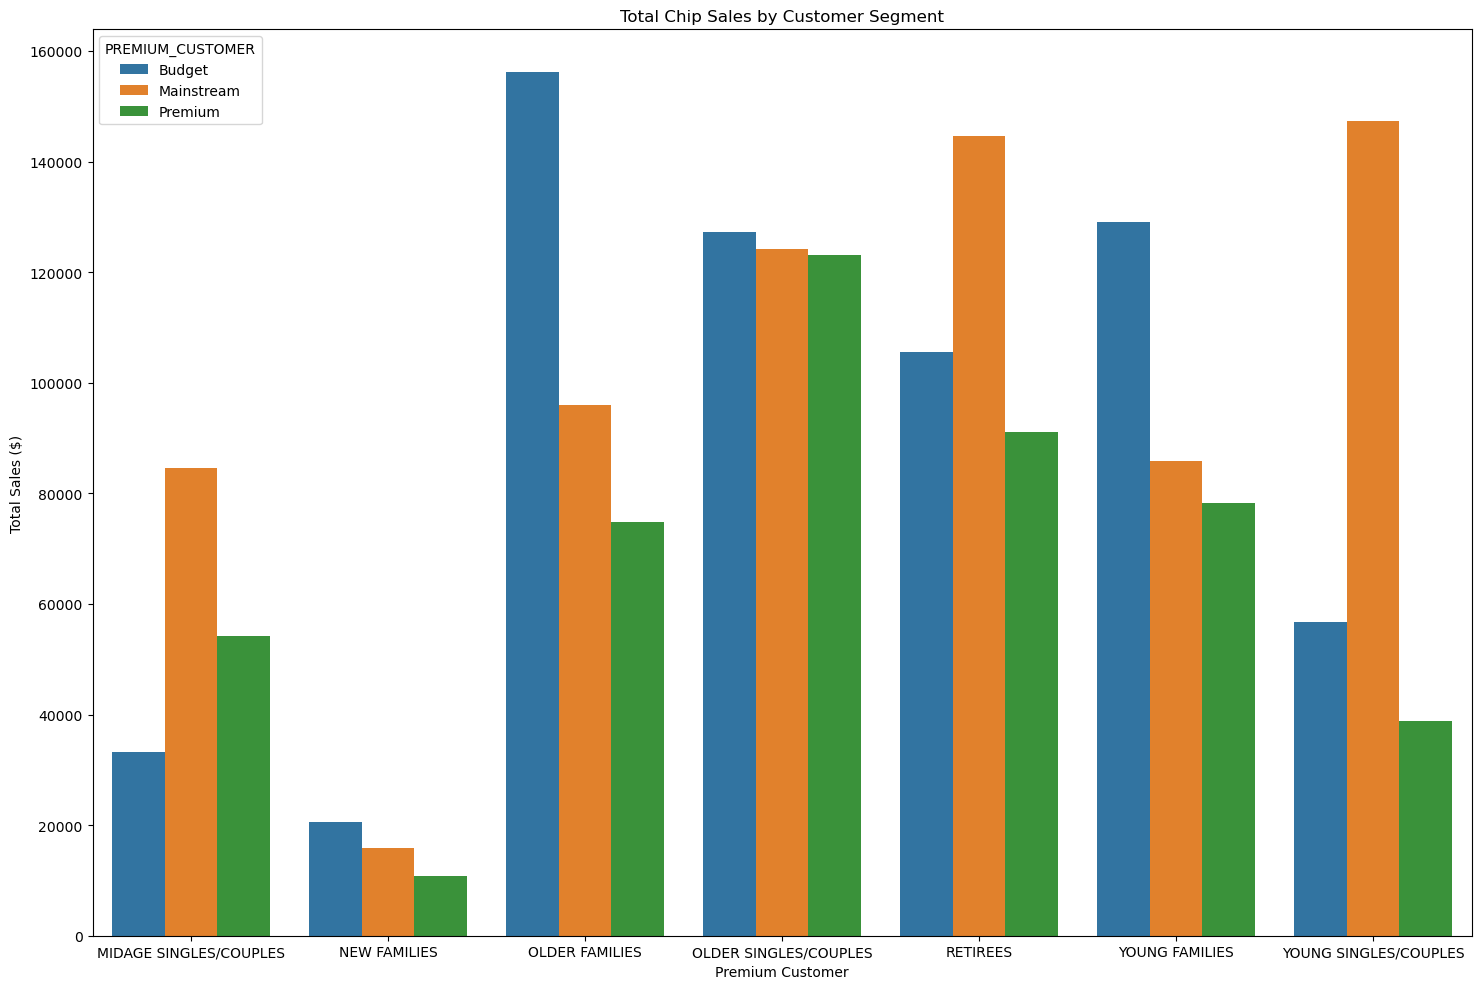

In [47]:
sales_summary = final.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().reset_index()

plt.figure(figsize = (15,10))
sns.barplot(x = 'LIFESTAGE', y = 'TOT_SALES', data = sales_summary, hue = 'PREMIUM_CUSTOMER')
plt.title('Total Chip Sales by Customer Segment')
plt.ylabel('Total Sales ($)')
plt.xlabel('Premium Customer')
plt.tight_layout()
plt.show()

The bar chart above shows the total sales by different customer segments.
The majority of chip consumers are from **BUDGET-OLDER FAMILIES** and we also discovered that the older people of the customer have stable and strong contributions to the chip sales compared to the younger generations.  

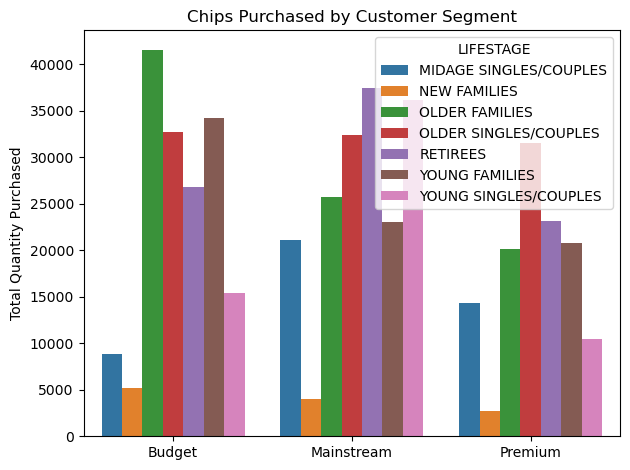

In [49]:
# What types of families purchase chips the most?
quantity_summary = final.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['PROD_QTY'].sum().reset_index()

sns.barplot(x = 'PREMIUM_CUSTOMER', y = 'PROD_QTY', data = quantity_summary, hue = 'LIFESTAGE')
plt.title('Chips Purchased by Customer Segment')
plt.ylabel('Total Quantity Purchased')
plt.xlabel('')
plt.tight_layout()
plt.show()

It is noticeable that over half of chip consumers are classified as either **old individuals or retirees**. 

It is suggested that the primary customer base for chips tends to be older demographics, rather than younger families or singles. Further segmentation by age could provide deeper insights, enabling the company to more precisely target marketing efforts towards specific age groups within this core customer segment.

3. Product Popularity

The overall Product Share

top_chips = final.groupby('PROD_NBR')['TOT_SALES'].sum().sort_values(ascending = False).reset_index()
total_revenue = yearly_spent['TOT_SALES'].sum()
top_chips['Revenue_share'] = round((top_chips['TOT_SALES'] / total_revenue) *100, 2)
fig = px.treemap(top_chips, path = ['PROD_NBR'], values = 'TOT_SALES')
fig.show()

top_chips_by_group = final.groupby(['PREMIUM_CUSTOMER', 'PROD_NBR', 'PROD_NAME'])['TOT_SALES'].sum().reset_index()
top_5_chips_by_group = top_chips_by_group.groupby('PREMIUM_CUSTOMER').apply(
    lambda x: x.sort_values('TOT_SALES', ascending = False).head(5)
)
top_5_chips_by_group['PROD_NBR'] = top_5_chips_by_group['PROD_NBR'].astype(str)
sns.barplot(x = 'PREMIUM_CUSTOMER', y = 'TOT_SALES', hue = 'PROD_NBR', data = top_5_chips_by_group, palette='Paired')

From the above charts, the chips with product numbers 4, 14, 16, 102, and 7 are identified as the top 5 most popular products overall. The Budget and Mainstream customer groups generally follow this overall chips popularity pattern. 

However, in the Premium customer group, product number 7 stands out. While Chips 7 ranks 5th overall in total sales, it only shows be loved by Premium customers which ranking in 3rd place for Premium customers.

This suggests that factors beyond price may be influencing Premium customers' purchasing decisions, attracting them specifically to product 7 and contributing to high revenue for the company. 

# might be something associated with chip flavor or size.
top_5_chips_by_group['size'] = top_5_chips_by_group['PROD_NAME'].str.split().str[-1]
top_5_chips_by_group

Chip size over 300g is the top choice across all customer groups, except for the Kettle Mozzarella Basil & Pesto 175g chip, which is notably popular among all groups.The company might start to consider promoting larger size for this chip. 